In [32]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import argparse
import numpy as pb
import glob

# Gray Level Transform

## Linear gray level transformation

In [33]:
def linear_gray_level_transformation(img, alpha, beta):
    new_img = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)
    return new_img

## Piecewise_linear_transformation

In [34]:
def piecewise_linear_transformation(img, threshold, low_slope, high_slope, intercept_low=0, intercept_high=0):
    new_img = img.copy()
    lower_mask = new_img < threshold
    higher_mask = new_img >= threshold
    new_img[lower_mask] = np.clip(low_slope * img[lower_mask] + intercept_low, 0, 255)
    new_img[higher_mask] = np.clip(high_slope * img[higher_mask] + intercept_high, 0, 255)
    return new_img

## Logarit

In [35]:
def logarithmic_transformation(img, constant=1):
     # Adding 1 to the image to avoid log(0)
    img = np.float32(img) + 1  # Convert to float to avoid overflow issues during log computation

    # Apply the logarithmic transformation
    log_image = constant * np.log(img)

    # Normalize the output to ensure it lies in the range 0-255
    log_image = cv2.normalize(log_image, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    return log_image

## Gamma

In [36]:
def adjust_gamma(img, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    
    gamma_corrected = cv2.LUT(img, table)
    return gamma_corrected

# Histogram

## HE

In [37]:
def hist_equalization(img):
    """ Normal Histogram Equalization

    Args:
        img : image input with single channel

    Returns:
        : Equalized Image
    """
    array = pb.asarray(img)
    bin_cont = pb.bincount(array.flatten(), minlength=256)
    pixels = pb.sum(bin_cont)
    bin_cont = bin_cont / pixels
    cumulative_sumhist = pb.cumsum(bin_cont)
    map = pb.floor(255 * cumulative_sumhist).astype(pb.uint8)
    arr_list = list(array.flatten())
    eq_arr = [map[p] for p in arr_list]
    arr_back = pb.reshape(pb.asarray(eq_arr), array.shape)
    return arr_back

## AHE

In [38]:
def apply_ahe(img, tile_grid_size=(8, 8)):
    # Function to apply AHE on a single channel
    def ahe_channel(channel):
        height, width = channel.shape
        x_tiles = int(np.ceil(width / tile_grid_size[0]))
        y_tiles = int(np.ceil(height / tile_grid_size[1]))
        output_channel = np.zeros_like(channel)

        for y in range(y_tiles):
            for x in range(x_tiles):
                start_x = x * tile_grid_size[0]
                start_y = y * tile_grid_size[1]
                end_x = min(start_x + tile_grid_size[0], width)
                end_y = min(start_y + tile_grid_size[1], height)

                tile = channel[start_y:end_y, start_x:end_x]
                equalized_tile = cv2.equalizeHist(tile)
                output_channel[start_y:end_y, start_x:end_x] = equalized_tile

        return output_channel

    # Check if the image is grayscale or color
    if len(img.shape) == 2:
        # Grayscale image
        return ahe_channel(img)
    elif len(img.shape) == 3:
        # Color image, apply AHE to each channel
        channels = cv2.split(img)
        equalized_channels = [ahe_channel(channel) for channel in channels]
        return cv2.merge(equalized_channels)

## CLAHE

In [39]:
def apply_clahe(img, clip_limit=2.0, tile_grid_size=(8, 8)):
    # Check if the image is grayscale; if not, convert to grayscale
    if len(img.shape) > 2 and img.shape[2] == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Create a CLAHE object
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)

    # Apply CLAHE to the grayscale image
    clahe_img = clahe.apply(img)

    return clahe_img

# Retinex

## SSR

In [40]:
def single_scale_retinex(img, sigma):
    retinex = cv2.log(cv2.add(np.float64(img), 1.0)) - cv2.log(cv2.GaussianBlur(np.float64(img), (0, 0), sigma) + 1.0)
    retinex_normalized = ((retinex - retinex.min()) / (retinex.max() - retinex.min())) * 255.0
    return retinex_normalized.astype(np.uint8)

## MSR

In [41]:
def multi_scale_retinex(img, sigma_list):
    retinex = np.zeros_like(np.float64(img))
    for sigma in sigma_list:
        retinex += single_scale_retinex(img, sigma)
    retinex = ((retinex - retinex.min()) / (retinex.max() - retinex.min())) * 255.0
    return retinex.astype(np.uint8)

## MSRCR

In [42]:
def simplest_color_balance(img, low_clip, high_clip):
    total = img.shape[0] * img.shape[1]
    for i in range(img.shape[2]):
        unique, counts = np.unique(img[:, :, i], return_counts=True)
        current = 0
        for u, c in zip(unique, counts):
            if current < low_clip * total:
                low_val = u
            if current < high_clip * total:
                high_val = u
            current += c
        img[:, :, i] = np.maximum(np.minimum(img[:, :, i], high_val), low_val)
    return img

def MSRCR(img, sigma_list):
    img = np.float64(img) + 1.0
    img_retinex = multi_scale_retinex(img, sigma_list)
    img_color = simplest_color_balance(img_retinex, 0.01, 0.99)
    for i in range(img.shape[2]):
        img_color[:, :, i] = (img_color[:, :, i] - np.min(img_color[:, :, i])) / (np.max(img_color[:, :, i]) - np.min(img_color[:, :, i])) * 255
    img_color = np.uint8(np.minimum(np.maximum(img_color, 0), 255))
    return img_color

# Read data

In [43]:
dicm = cv2.cvtColor(cv2.imread('./static/img/input/DICM/21.JPG'), cv2.COLOR_BGR2RGB)
fusion = cv2.cvtColor(cv2.imread('./static/img/input/Fusion/1.jpg'), cv2.COLOR_BGR2RGB)
lime = cv2.cvtColor(cv2.imread('./static/img/input/LIME/1.bmp'), cv2.COLOR_BGR2RGB)
low = cv2.cvtColor(cv2.imread('./static/img/input/low/Daybreak&Nightfall  (1).JPG'), cv2.COLOR_BGR2RGB)
mef = cv2.cvtColor(cv2.imread('/Users/HUS/CV/bt/app/static/img/input/MEF/A.png'), cv2.COLOR_BGR2RGB)
npe = cv2.cvtColor(cv2.imread('./static/img/input/NPE/cloudy (1)_jpeg.jpeg'), cv2.COLOR_BGR2RGB)
vv = cv2.cvtColor(cv2.imread('./static/img/input/VV/P1040134.jpg'), cv2.COLOR_BGR2RGB)

[ WARN:0@16875.666] global loadsave.cpp:244 findDecoder imread_('./static/img/input/DICM/21.JPG'): can't open/read file: check file path/integrity


error: OpenCV(4.7.0) /Users/xperience/GHA-OCV-Python/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


# Test

In [ ]:
# Test thì đổi tên ảnh trong test_img = (ảnh mới).copy()
mef = cv2.cvtColor(cv2.imread('/Users/HUS/CV/bt/app/static/img/input/MEF/A.png'), cv2.COLOR_BGR2RGB)
img = mef.copy()

# Gray Trans
linear = linear_gray_level_transformation(img, alpha=0.5, beta=50)
piece = piecewise_linear_transformation(img, threshold=128, low_slope=0.5, high_slope=2)
log = logarithmic_transformation(img, constant= 1)
gamma = adjust_gamma(img, gamma=10)

# Histogram

he = hist_equalization(img)
ahe = apply_ahe(img)
clahe = apply_clahe(img)

# retinex

ssr = single_scale_retinex(img, sigma=10)
msr = multi_scale_retinex(img, sigma_list=[10, 50, 100])
msrcr = MSRCR(img, sigma_list=[10, 50, 100])


In [51]:
import os

input_folder = "./static/img/input/VV"

# Tạo thư mục chứa kết quả
output_folder = "./static/img/output/VV"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Lặp qua tất cả các file trong thư mục input
for filename in os.listdir(input_folder):
    if filename.endswith((".jpg", ".png", ".jpeg", ".bmp")):
        # Đọc ảnh gốc
        img_path = os.path.join(input_folder, filename)
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

        # Tạo thư mục kết quả dựa trên tên ảnh
        output_subfolder = os.path.join(output_folder, os.path.splitext(filename)[0])
        if not os.path.exists(output_subfolder):
            os.makedirs(output_subfolder)

        # Áp dụng các phương pháp chuyển đổi và lưu kết quả
        result1 = linear_gray_level_transformation(img, alpha=0.5, beta=50)  
        cv2.imwrite(output_subfolder + '/linear.jpg', cv2.cvtColor(result1, cv2.COLOR_BGR2RGB))

        result2 = piecewise_linear_transformation(img, threshold=128, low_slope=0.5, high_slope=2)  
        cv2.imwrite(output_subfolder + '/piecewise.jpg', cv2.cvtColor(result2, cv2.COLOR_BGR2RGB))

        result3 = logarithmic_transformation(img, constant= 1)  
        cv2.imwrite(output_subfolder + '/log.jpg', cv2.cvtColor(result3, cv2.COLOR_BGR2RGB))

        result4 = adjust_gamma(img, gamma=10)  
        cv2.imwrite(output_subfolder + '/gamma.jpg', cv2.cvtColor(result4, cv2.COLOR_BGR2RGB))

        result5 = hist_equalization(img)  
        cv2.imwrite(output_subfolder + '/he.jpg', cv2.cvtColor(result5, cv2.COLOR_BGR2RGB))

        result6 = apply_ahe(img) 
        cv2.imwrite(output_subfolder + '/ahe.jpg', cv2.cvtColor(result6, cv2.COLOR_BGR2RGB))

        result7 = apply_clahe(img)  
        cv2.imwrite(output_subfolder + '/clahe.jpg', cv2.cvtColor(result7, cv2.COLOR_BGR2RGB))

        result8 = single_scale_retinex(img, sigma=10)
        cv2.imwrite(output_subfolder + '/ssr.jpg', cv2.cvtColor(result8, cv2.COLOR_BGR2RGB))

        result9 = multi_scale_retinex(img, sigma_list=[10, 50, 100])
        cv2.imwrite(output_subfolder + '/msr.jpg', cv2.cvtColor(result9, cv2.COLOR_BGR2RGB))

        result10 = MSRCR(img, sigma_list=[10, 50, 100])  
        cv2.imwrite(output_subfolder + '/msrcr.jpg', cv2.cvtColor(result10, cv2.COLOR_BGR2RGB))

In [ ]:
img = cv2.cvtColor(cv2.imread(file_path), cv2.COLOR_BGR2RGB)
transformed_img = linear_gray_level_transformation(img, alpha=0.5, beta=50)

# Lưu ảnh đã biến đổi vào thư mục đích
output_file_path = os.path.join(output_folder_path, file_name + '.JPG')
cv2.imwrite(output_file_path, cv2.cvtColor(transformed_img, cv2.COLOR_BGR2RGB))

True

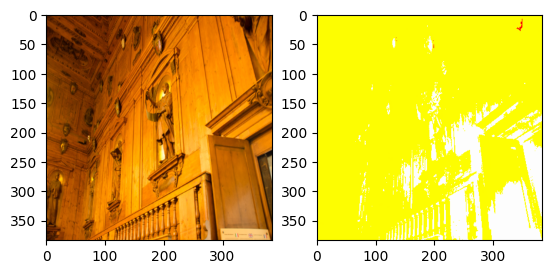

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def single_scale_retinex(img, sigma):
    retinex = cv2.log(cv2.add(np.float64(img), 1.0)) - cv2.log(cv2.GaussianBlur(np.float64(img), (0, 0), sigma) + 1.0)
    return retinex

img = cv2.cvtColor(cv2.imread('./static/img/input/Brightening/r0a2e85f0t.png'), cv2.COLOR_BGR2RGB)
plt.subplot(1, 2, 1)
plt.imshow(img)

transformed_img = single_scale_retinex(img, sigma=10)
transformed_img = (transformed_img - np.min(transformed_img)) / (np.max(transformed_img) - np.min(transformed_img)) * 255.0
transformed_img = transformed_img.astype(np.uint8)

plt.subplot(1, 2, 2)
plt.imshow(transformed_img)
cv2.imwrite('test.JPG', cv2.cvtColor(transformed_img, cv2.COLOR_RGB2BGR))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


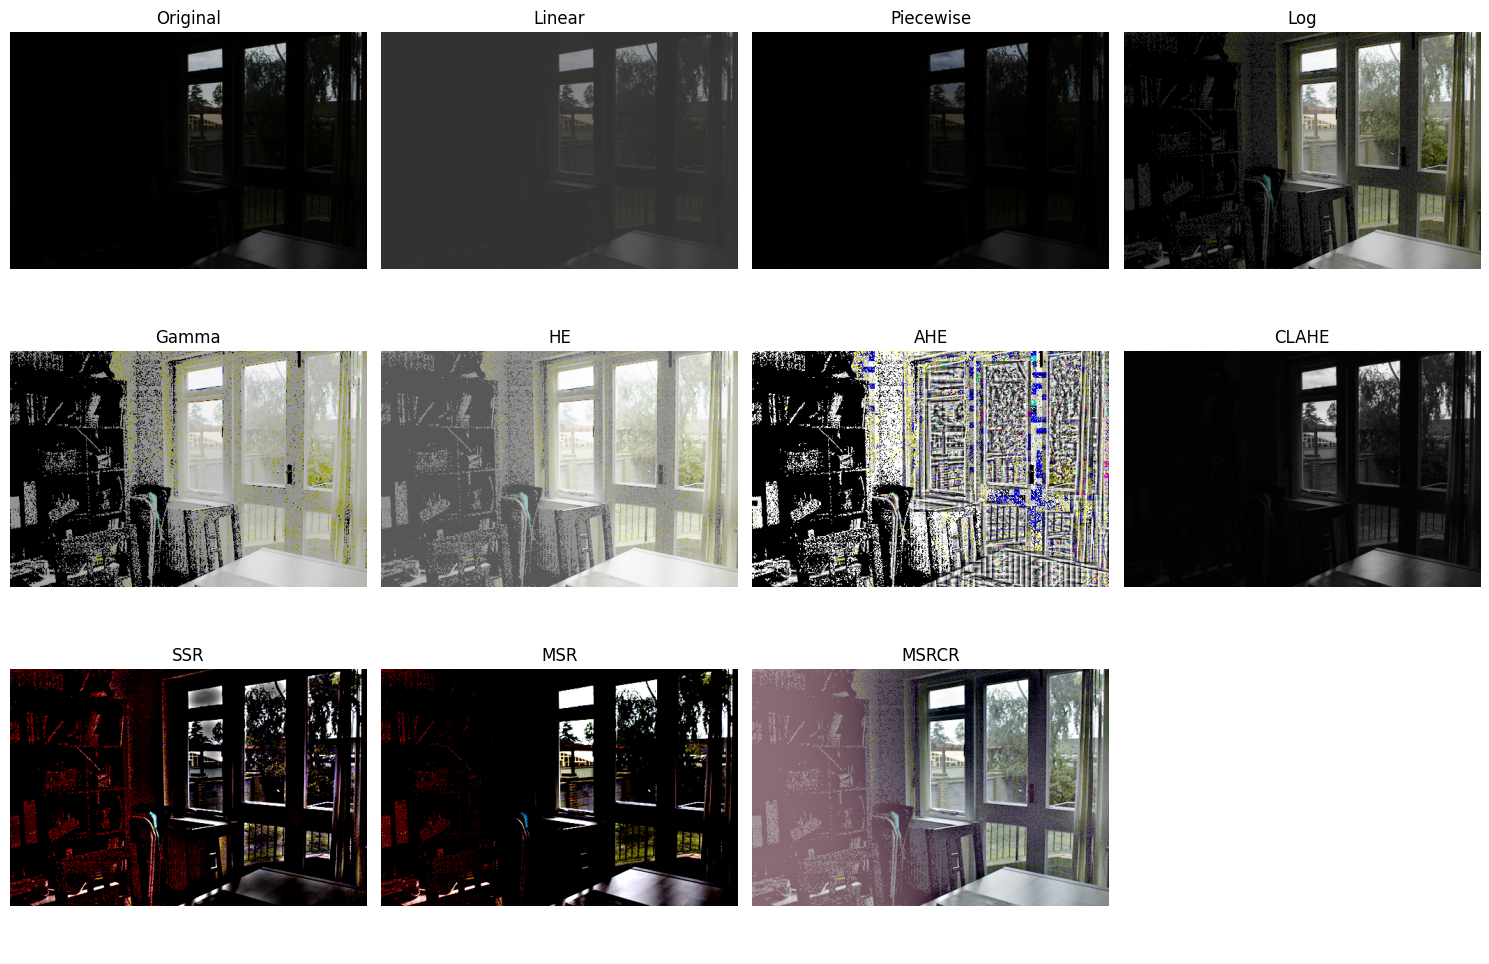

In [ ]:
# List of images and titles
images = [test_img, linear, piece, log, gamma, he, ahe, clahe, ssr, msr, msrcr]
titles = ["Original", "Linear", "Piecewise", "Log", "Gamma", "HE", "AHE", "CLAHE", "SSR", "MSR", "MSRCR"]

# Create subplots
rows = 3
cols = 4
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

for i, ax in enumerate(axes.flat):
    if i < len(images):
        ax.imshow(images[i], cmap='gray')
        ax.set_title(titles[i])
    ax.axis('off')

# Adjust subplot parameters for better layout
plt.tight_layout()
plt.show()

# Test Kết hợp

In [ ]:
test_img = vv.copy()

In [ ]:
he = hist_equalization(test_img)

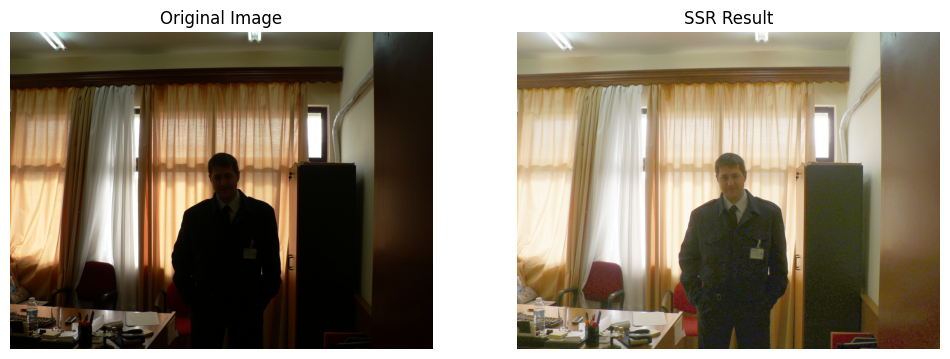

In [ ]:
# Display the original and the SSR result using matplotlib
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(test_img)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(he)
plt.title('SSR Result')
plt.axis('off')

plt.show()